In [4]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.style.use('~/Python_Tool/ryan_mplstyle.mplstyle')

In [5]:
Ro = 0.1
Bu = 8

Ly_instab = 8
Ly = Ly_instab*4
Ny = 256
Lx = Ly*2
Nx = Ny*2

if_ridig = 2

In [8]:
dtype = np.complex128
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ComplexFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2))

integ =  lambda A: d3.Integrate(A, ('y'))

psi2_sharp = dist.Field(bases=ybasis )
bump = dist.Field(bases=ybasis )

# Fields
q1 = dist.Field(bases=ybasis )
q2 = dist.Field(bases=ybasis )
psi1 = dist.Field(bases=ybasis )
psi2 = dist.Field(bases=ybasis )

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])

y = dist.local_grids(ybasis); y = y[0]

####
psi2_sharp['g'] = 0
ysel = (y>=-2*Ly_instab) & (y<=-Ly_instab)
psi2_sharp['g'][ysel] = np.cos( (y[ysel]+2*Ly_instab)/Ly_instab*np.pi )*Ly_instab
ysel = (y>=0) & (y<=Ly_instab)
psi2_sharp['g'][ysel] = -np.cos( (y[ysel])/Ly_instab*np.pi )*Ly_instab
psi2_sharp['g'][(y>=-Ly_instab) & (y<=0)] = -Ly_instab
psi2_sharp['g'][(y>=Ly_instab) & (y<=2*Ly_instab)] = Ly_instab

###
bump_w = Ly_instab/6
bump['g'] = 0
yl = y[(y>=-bump_w) & (y<=bump_w)]
bump['g'][(y>=-bump_w) & (y<=bump_w)] = np.exp(-1/(1-(yl/bump_w)**2))
binteg = (integ(bump).evaluate()['g'][0])
bump['g'] = bump['g']/binteg

###
psi2['c'] = -psi2_sharp['c']*bump['c']*Ly
# psi2['c'] = -psi2_sharp['c']
psi1['g'] = -psi2['g']

###
prob_qper = d3.LBVP([q1, q2], namespace=locals())

prob_qper.add_equation("q1=dy(dy(psi1))+(psi2-if_ridig*psi1)/Bu")
prob_qper.add_equation("q2=dy(dy(psi2))+(psi1-psi2)/Bu")

# prob_qper.add_equation("q1= ((1+Ro*dy(dy(psi1))) / (1+Ro/Bu*(if_ridig*psi1-psi2))-1)/Ro")
# prob_qper.add_equation("q2= ((1+Ro*dy(dy(psi2))) / (1+Ro/Bu*(psi2-psi1))-1)/Ro")

solv_qper = prob_qper.build_solver()
solv_qper.solve()

#########################
y_perio = y
q1_perio = np.real(q1['g'])
q2_perio = np.real(q2['g'])

dealias = 3/2
dtype = np.float64
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

yavg = lambda A: d3.Average(A, ('y'))

y = dist.local_grids(ybasis); y = y[0].ravel()

q1 = dist.Field(bases=ybasis )
q2 = dist.Field(bases=ybasis )

q1['g'] = q1_perio
q2['g'] = q2_perio

#####
q1_sv = dist.Field(bases=ybasis )
q2_sv = dist.Field(bases=ybasis )

problem = d3.IVP([q1_sv, q2_sv], namespace=locals())

problem.add_equation("q1_sv = q1")
problem.add_equation("q2_sv = q2")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 10

solver.step(1e-10); 

ICname = "MeanPV_%.2f_%.3f_%d" %(Ly_instab, Ro, Nx)
ICname = ICname.replace(".", "d" ); ICname = ICname
snapshots = solver.evaluator.add_file_handler(ICname, sim_dt=1e-10, max_writes=10)
snapshots.add_task(-(-q1_sv), name='Q1_init')
snapshots.add_task(-(-q2_sv), name='Q2_init')

solver.step(1e-10); solver.step(1e-10); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9)

2024-08-21 15:38:39,323 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+02/s
2024-08-21 15:38:39,347 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+02/s


In [11]:
dtype = np.complex128
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ComplexFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2))

integ =  lambda A: d3.Integrate(A, ('y'))

psi1 = dist.Field(bases=ybasis )
psi2 = dist.Field(bases=ybasis )
u1 = dist.Field(bases=ybasis )
u2 = dist.Field(bases=ybasis )
h1 = dist.Field(bases=ybasis )
h2 = dist.Field(bases=ybasis )

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])

y = dist.local_grids(ybasis); y = y[0]

###
psi2['c'] = -psi2_sharp['c']*bump['c']*Ly
psi1['g'] = -psi2['g']

# psi2['c'] = 0
# psi1['g'] = 0

###
prob_qper = d3.LBVP([u1, u2, h1, h2], namespace=locals())

prob_qper.add_equation("u1 = -dy(psi1)")
prob_qper.add_equation("u2 = -dy(psi2)")
prob_qper.add_equation("h1 = if_ridig*psi1-psi2")
# prob_qper.add_equation("h1 = psi1-psi2")
prob_qper.add_equation("h2 = psi2-psi1")

solv_qper = prob_qper.build_solver()
solv_qper.solve()

#########################
y_perio = y
u1_perio = np.real(u1['g'])
u2_perio = np.real(u2['g'])
h1_perio = np.real(h1['g'])
h2_perio = np.real(h2['g'])

dealias = 3/2
dtype = np.float64
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=dealias)

yavg = lambda A: d3.Average(A, ('y'))

y = dist.local_grids(ybasis); y = y[0].ravel()

u1 = dist.Field(bases=ybasis )
u2 = dist.Field(bases=ybasis )
h1 = dist.Field(bases=ybasis )
h2 = dist.Field(bases=ybasis )

####
u1['g'] = u1_perio
u2['g'] = u2_perio
h1['g'] = h1_perio
h2['g'] = h2_perio

#####
u1_sv = dist.Field(bases=ybasis )
u2_sv = dist.Field(bases=ybasis )
h1_sv = dist.Field(bases=ybasis )
h2_sv = dist.Field(bases=ybasis )

problem = d3.IVP([u1_sv, u2_sv, h1_sv, h2_sv], namespace=locals())

problem.add_equation("u1_sv = u1")
problem.add_equation("u2_sv = u2")
problem.add_equation("h1_sv = h1")
problem.add_equation("h2_sv = h2")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 10

solver.step(1e-10); 

ICname = "MeanSW_%.2f_%.3f_%d" %(Ly_instab, Ro, Nx)
ICname = ICname.replace(".", "d" ); ICname = ICname
snapshots = solver.evaluator.add_file_handler(ICname, sim_dt=1e-10, max_writes=10)
snapshots.add_task(-(-u1_sv), name='u1')
snapshots.add_task(-(-u2_sv), name='u2')
snapshots.add_task(-(-h1_sv), name='h1')
snapshots.add_task(-(-h2_sv), name='h2')

solver.step(1e-10); solver.step(1e-10); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9); solver.step(1e-9)

2024-08-21 15:38:45,235 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2024-08-21 15:38:45,262 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+02/s


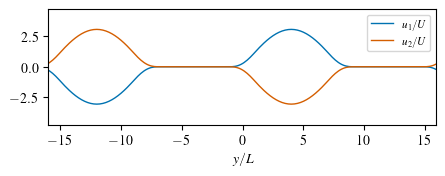

In [29]:
u1_sv.change_scales(1)
u2_sv.change_scales(1)

fig = plt.figure(figsize=(5, 1.5))

plt.plot(y, u1_sv['g'].ravel(),label="$u_1/U$")
plt.plot(y, u2_sv['g'].ravel(),label="$u_2/U$")

plt.axis('equal')
plt.xlabel("$y/L$")
plt.legend()

figname = 'figs/init_bickely_jet.pdf'
plt.savefig(figname, bbox_inches='tight')
plt.show()